# Проект по тарифам для телеком-компании

# Описание проекта

Компания «Мегалайн» — федеральный оператор сотовой связи. 
Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.


Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. Имеем данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


Описание тарифов

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей


**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 1 рубль

сообщение: 1 рубль

1 Гб интернет-трафика: 150 рублей





**ПЛАН**

1. Открыть данные, посмотреть что в них. Исправить выбросы / пропуски / типы
2. Посчитаем для каждого пользователя нужные параметры : 
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя


3. Разделим данные клиентов по тарифам, посчитаем нужные значения (дисперсия, станд отклонение и среднее)

4. Обозначим гипотезы и для каждой формулируем нулевую и альтернативную. Определимся с критерием проверки
5. Проверим гипотезы и сформулиируем общий вывод




In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import date
import math
import numpy as np
from scipy import stats

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv')
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

## Посмотрим на данные

### Таблица calls

In [3]:
# просмотрим каждую таблицу отдельно 
calls.info()
# переделаем дату из object в datetime64, пропусков нет

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
calls.call_date = pd.to_datetime(calls.call_date)

In [5]:
calls.duplicated().sum()
# нет дубликатов

0

### Таблица internet (информация об интернет-сессиях):

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

Видим колонку Unnamed: 0, дропнем её

In [6]:
internet.head(3)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


In [7]:
internet = internet.drop('Unnamed: 0', axis=1)
internet.head(3)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [9]:
# опять исправим только тип даты
internet.session_date = pd.to_datetime(internet.session_date)

###  Таблица messages (информация о сообщениях):

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [11]:
messages.message_date = pd.to_datetime(messages.message_date)

### Таблица tariffs (информация о тарифах):

* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [12]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


#### Таблица users (информация о пользователях):

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [13]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [14]:
users.reg_date = pd.to_datetime(users.reg_date)

In [15]:
# заполним пропуски в churn_date сегодняшней датой - тариф всё ещё действует
today = date.today()
users['churn_date'] = users['churn_date'].fillna(today)

### У нас могут быь пользователи которые не пользуются услугами

Найдем количество тех, кто не пользуется интернетом, сообщениями или другими услугами

In [16]:
users_total = users.user_id.nunique()
# число пользователей всего

users_out_of_calls = users_total - calls.user_id.nunique()
users_out_of_messages = users_total - messages.user_id.nunique()
users_out_of_internet = users_total - internet.user_id.nunique()

print('users_out_of_calls = ', users_out_of_calls)
print('users_out_of_messages', users_out_of_messages)
print('users_out_of_internet', users_out_of_internet)

users_out_of_calls =  8
users_out_of_messages 74
users_out_of_internet 3


**видим что сообщениями не пользуются больше всего**

## Посчитаем для каждого пользователя:
### количество сделанных звонков и израсходованных минут разговора по месяцам


In [17]:
# добавим колонку месяца
calls['month'] = pd.DatetimeIndex(calls.call_date).month

In [18]:
# создаём таблицу с количеством звонков
calls_piv_count = pd.pivot_table(calls, index = 'user_id', columns = 'month',values = 'id' , aggfunc = 'count')
calls_piv_count.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0


In [19]:
# часть данных заполняется какими то пропусками
# это потому что таких данных в таблице просто нет, можем их заполнить 0
calls_piv_count = calls_piv_count.fillna(0)

Помним что каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута. Нужно округлить duration в большую сторону и посчитать для каждого пользователя количество израсходованных минут разговора по месяцам

In [20]:
calls['round_duration'] = np.ceil(calls.duration)

In [21]:
# создаём таблицу с длительностью звонков
calls_piv_sum = pd.pivot_table(calls, index = 'user_id', columns = 'month',values = 'round_duration' , aggfunc = 'sum')
# по той же логике NaN заполним 0
calls_piv_sum = calls_piv_sum.fillna(0)
calls_piv_sum.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,430.0,414.0
1002,0.0,0.0,0.0,0.0,0.0,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380.0,961.0,855.0,824.0,802.0
1004,0.0,0.0,0.0,0.0,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0


Итого:

количество сделанных звонков по месяцам лежит в calls_piv_count

количество израсходованный минут по месяцам - в calls_piv_sum

### Посчитаем количество отправленных сообщений по месяцам
всё по аналогии с тем, что выше :-)

In [22]:
# данные у нас только за 2018 год
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages.head(3)

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8


In [23]:
messages_piv_count = pd.pivot_table(data = messages, index = 'user_id', columns = 'month', values = 'id', aggfunc = 'count')
messages_piv_count = messages_piv_count.fillna(0)
messages_piv_count.head(3)

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,0.0,0.0,0.0,0.0,0.0,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,91.0,83.0,94.0,75.0


### Посчитаем объем израсходованного интернет-трафика по месяцам

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

In [24]:
internet['month'] = pd.DatetimeIndex(internet.session_date).month

In [25]:
internet_piv_sum = pd.pivot_table(internet, index = 'user_id', columns = 'month',\
                                  values = 'mb_used', aggfunc = 'sum')
internet_piv_sum = internet_piv_sum.fillna(0)

# переведём в гб, потом округлим в соответсвии с тарифом
internet_piv_sum = internet_piv_sum / 1024

# округлим в большую сторону
internet_piv_sum = np.ceil(internet_piv_sum)
internet_piv_sum.head(3)

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0.0,0.0,0.0,0.0,3.0,23.0,14.0,14.0,15.0,15.0,15.0,10.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,14.0
1002,0.0,0.0,0.0,0.0,0.0,11.0,18.0,20.0,17.0,14.0,19.0,18.0


### Считаем : помесячную выручку с каждого пользователя

(вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).


In [26]:
# переименуем tariff_name в  tariff
tariffs.columns = ['messages_included', 'mb_per_month_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute',
       'tariff']

Сначала объеденим основные таблицы со звонками, сообщениями, интернетом. Потом присоеденим остальные

In [27]:
# создадим общий датафрейм
messages_0 = messages.copy()

In [28]:
#создадим промежуточный датафрейм с числом использованных сообщений и прилепим к общему
messages_used = pd.DataFrame(messages_0.groupby(['user_id', 'month'])['id'].count()).reset_index().rename({'id':\
                                                         'messages_used_per_month'}, axis='columns')
messages_used.head(3)

,user_id,month,messages_used_per_month
0,1000,5,22
1,1000,6,60
2,1000,7,75


In [29]:
calls_used = pd.DataFrame(calls.groupby(['user_id', 'month'])['round_duration'].sum()\
                          .reset_index()).rename({'round_duration':'duration_calls_per_month'}, axis='columns')
calls_used.head(3)

,user_id,month,duration_calls_per_month
0,1000,5,159.0
1,1000,6,172.0
2,1000,7,340.0


In [30]:
internet_used = pd.DataFrame(internet.groupby(['user_id', 'month'])['mb_used'].sum().\
                             reset_index()).rename({'mb_used': 'mb_used_per_month'}, axis='columns')
internet_used.head(3)

,user_id,month,mb_used_per_month
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64


In [31]:
# последовательно присоединим к большому датафрейму данные из _used датафреймов

# исправила left на outer
messages_0 = messages_0.merge(messages_used, how = 'outer', on = ['user_id', 'month'])
messages_0 = messages_0.merge(calls_used, how = 'outer', on = ['user_id', 'month'])
messages_0 = messages_0.merge(internet_used, how = 'outer', on = ['user_id', 'month'])

In [32]:
# прилепим название тарифа каждому пользователю
messages_0 = messages_0.merge(users.loc[:,['user_id', 'tariff']], how = 'left', on = 'user_id')
# и добавим условия тарифа по сообщениям
messages_0 = messages_0.merge(tariffs, how = 'left', on = 'tariff')


Удалим ненужные колонки и появившиеся дубликаты

In [33]:
messages_0 = messages_0.drop(['message_date', 'id'], axis = 1).drop_duplicates()
messages_0

,user_id,month,messages_used_per_month,duration_calls_per_month,mb_used_per_month,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,6,60.0,172.0,23233.77,ultra,1000,30720,3000,1950,150,1,1
60,1000,10,73.0,350.0,14702.49,ultra,1000,30720,3000,1950,150,1,1
133,1000,8,81.0,408.0,14055.93,ultra,1000,30720,3000,1950,150,1,1
214,1000,12,70.0,333.0,9817.61,ultra,1000,30720,3000,1950,150,1,1
284,1000,11,58.0,338.0,14756.47,ultra,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123528,1494,9,NaN,501.0,16962.51,smart,50,15360,500,550,200,3,3
123529,1494,10,NaN,354.0,17767.24,smart,50,15360,500,550,200,3,3
123530,1494,11,NaN,411.0,18052.45,smart,50,15360,500,550,200,3,3
123531,1494,12,NaN,418.0,17621.21,smart,50,15360,500,550,200,3,3


Проведём расчёты

In [34]:
# округлим мб в соответсвии с тарифами
messages_0['mb_used_per_month'] = np.ceil(messages_0['mb_used_per_month'])
messages_0['gb_used_per_month'] = np.ceil(messages_0['mb_used_per_month'] / 1024)
# ----------------------------------------

# создадим по колонке с разницей использованного и по тарифу
# для сообщений
messages_0['mess_diff'] = messages_0['messages_used_per_month'] - messages_0['messages_included']
# для гб
messages_0['int_diff'] = messages_0['gb_used_per_month'] - messages_0['mb_per_month_included']/1024
# для звонков
messages_0['calls_diff'] = messages_0['duration_calls_per_month'] - messages_0['minutes_included']


# ----------------------------------------
# создадим по колонке с переплатой за сообщения / интернет / звонки
messages_0['overpay_mess'] = [0]*len(messages_0)
messages_0.loc[messages_0['mess_diff'] > 0, 'overpay_mess'] = messages_0['mess_diff']*messages_0['rub_per_message']

messages_0['overpay_calls'] = [0]*len(messages_0)
messages_0.loc[messages_0['calls_diff'] > 0, 'overpay_calls'] = messages_0['calls_diff']*messages_0['rub_per_minute']


messages_0['overpay_int'] = [0]*len(messages_0)
messages_0.loc[messages_0['int_diff'] > 0, 'overpay_int'] = np.ceil(messages_0['int_diff'])*messages_0['rub_per_gb']

In [35]:

# и наконец создадим столбец с итоговой оплатой за месяц
# это сумма переплат и абонентской платы

messages_0['total_pay_per_month'] = \
messages_0['rub_monthly_fee'] + messages_0['overpay_mess']+ messages_0['overpay_calls']+ messages_0['overpay_int']

In [36]:
# создадим отдельный датаврейм с нужными колонками
clients = messages_0.loc[:,['user_id', 'month', 'tariff', 
       'messages_used_per_month', 'duration_calls_per_month',
       'mb_used_per_month','gb_used_per_month' ,'overpay_mess', 'overpay_calls', 'overpay_int', 'total_pay_per_month']]

In [37]:
# итоговая таблица
clients

,user_id,month,tariff,messages_used_per_month,duration_calls_per_month,mb_used_per_month,gb_used_per_month,overpay_mess,overpay_calls,overpay_int,total_pay_per_month
0,1000,6,ultra,60.0,172.0,23234.0,23.0,0.0,0.0,0.0,1950.0
60,1000,10,ultra,73.0,350.0,14703.0,15.0,0.0,0.0,0.0,1950.0
133,1000,8,ultra,81.0,408.0,14056.0,14.0,0.0,0.0,0.0,1950.0
214,1000,12,ultra,70.0,333.0,9818.0,10.0,0.0,0.0,0.0,1950.0
284,1000,11,ultra,58.0,338.0,14757.0,15.0,0.0,0.0,0.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...
123528,1494,9,smart,NaN,501.0,16963.0,17.0,0.0,3.0,400.0,953.0
123529,1494,10,smart,NaN,354.0,17768.0,18.0,0.0,0.0,600.0,1150.0
123530,1494,11,smart,NaN,411.0,18053.0,18.0,0.0,0.0,600.0,1150.0
123531,1494,12,smart,NaN,418.0,17622.0,18.0,0.0,0.0,600.0,1150.0


Получили таблицу в которой для каждого пользователя посчитаны израсходованные по тарифу и сверх тарифа показатели, какой была переплата и итоговую выручку с каждого пользователя

## Проанализируем данные

Найдём:

* Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? 

* Посчитаем среднее количество, дисперсию и стандартное отклонение. + гистограммы. 

In [38]:
# делим данные по двум тарифам
smart = clients[clients['tariff'] == 'smart']
ultra = clients[clients['tariff'] == 'ultra']

### SMART
Будем считать статистики для ГС

#### Сообщения

<AxesSubplot:>

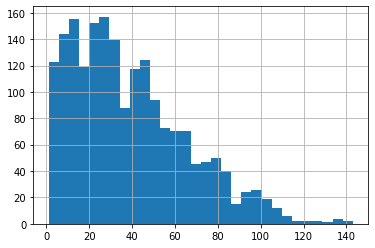

In [39]:
# Распределение использованных сообщений - близко к распределению пуассона
smart['messages_used_per_month'].hist(bins = 30)

In [40]:
smart['messages_used_per_month'].describe()

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: messages_used_per_month, dtype: float64

In [41]:
np.var(smart['messages_used_per_month'])

717.2208431102254

Видим что среднее = 39 сообщений/месяц

Станд отклонение = примерно 26,7

Дисперсия = 717

##### Звонки

<AxesSubplot:>

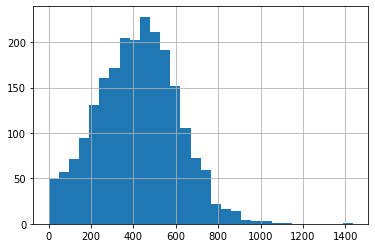

In [42]:
# распределение минут - ближе к нормальному
smart['duration_calls_per_month'].hist(bins = 30)

In [43]:
print(np.var(smart['duration_calls_per_month']))
smart['duration_calls_per_month'].describe()

35828.065309530335


count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: duration_calls_per_month, dtype: float64

Среднее =  419

Станд отклонение = 189

Дисперсия = 35828

##### Интернет

<AxesSubplot:>

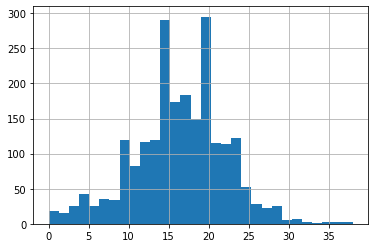

In [44]:
# близко к нормальному
smart['gb_used_per_month'].hist(bins = 30)

In [45]:
print(np.var(smart['gb_used_per_month']))
smart['gb_used_per_month'].describe()


32.90897855432254


count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used_per_month, dtype: float64

Среднее =  16

Станд отклонение = 5.7

Дисперсия = 32

### ULTRA

Считаем всё аналогично

#### Сообщения

In [46]:
print(np.var(ultra['messages_used_per_month']))
ultra['messages_used_per_month'].describe()

2107.0055235156888


count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: messages_used_per_month, dtype: float64

Среднее =  61

Станд отклонение = 46

Дисперсия = 2107

<AxesSubplot:>

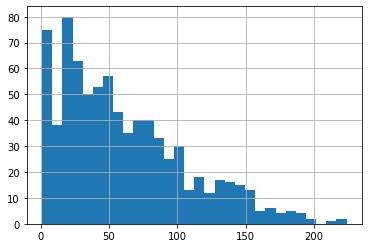

In [47]:
ultra['messages_used_per_month'].hist(bins = 30)

#### Звонки

In [48]:
print(np.var(ultra['duration_calls_per_month']))
ultra['duration_calls_per_month'].describe()

94104.36117385987


count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: duration_calls_per_month, dtype: float64

Среднее =  545

Станд отклонение = 307

Дисперсия = 94104

<AxesSubplot:>

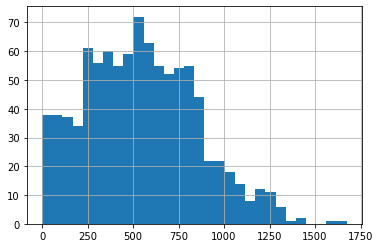

In [49]:
ultra['duration_calls_per_month'].hist(bins = 30)

#### Интернет

In [50]:
print(np.var(ultra['gb_used_per_month']))
ultra['gb_used_per_month'].describe()

94.05017330703485


count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used_per_month, dtype: float64

<AxesSubplot:>

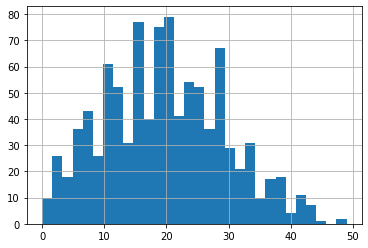

In [51]:
ultra['gb_used_per_month'].hist(bins = 30)

Среднее =  19

Станд отклонение = 9.7

Дисперсия = 94

## Гипотезы

### Первая гипотеза -- сравниваем тарифы
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;


H_0 : Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковы (равны) 

H_1 : Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равны

Дисперсия выручки smart =  669485.2209234157


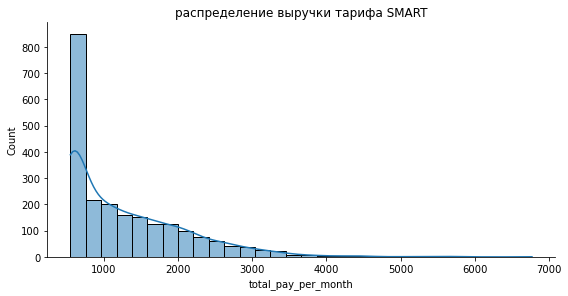

In [52]:
# посмотрим на распределение выручки тарифа SMART и на дисперсию
sns.displot(smart['total_pay_per_month'], kde=True, height=4, aspect=2, bins = 30)
plt.title('распределение выручки тарифа SMART')
print('Дисперсия выручки smart = ', np.var(smart['total_pay_per_month']))

Дисперсия выручки ultra =  141373.0732562024


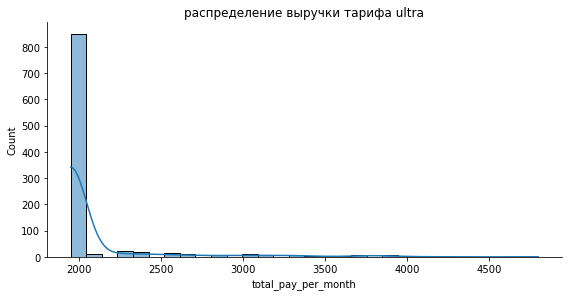

In [53]:
# а теперь ULTRA
sns.displot(ultra['total_pay_per_month'], kde=True, height=4, aspect=2,bins = 30)
plt.title('распределение выручки тарифа ultra')
print('Дисперсия выручки ultra = ', np.var(ultra['total_pay_per_month']))

Видим что пользователи SMART (Ежемесячная плата: 550 рублей) чаще выходят за пределы лимитов и переплачивают, а пользователям ULTRA обычно хватает базового пакета (Ежемесячная плата: 1950 рублей)

Дисперсии не равны, тк пользователь не помеж использовать два тарифа одновременно - используем ttest_ind (для независимых выборок)

In [54]:
# задалим пороговое значение pvalue = 0,05
stats.ttest_ind(smart['total_pay_per_month'], ultra['total_pay_per_month'], equal_var = False)

Ttest_indResult(statistic=-37.019021231454644, pvalue=4.2606313931076085e-250)

---
<div class="alert alert-info">
 
для порогового значения альфа = 0,05: 
   
    
 p-value много меньше 0,05
    
   Можем отвергнуть нулевую гиполезу
</div>

---

### Вторая гипотеза -- сравниваем регионы

* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

H_0 : средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.

H_1 : средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов.


In [55]:
clients.head(3)
# в таблице нет данных о регионе, нужно добавить их

,user_id,month,tariff,messages_used_per_month,duration_calls_per_month,mb_used_per_month,gb_used_per_month,overpay_mess,overpay_calls,overpay_int,total_pay_per_month
0,1000,6,ultra,60.0,172.0,23234.0,23.0,0.0,0.0,0.0,1950.0
60,1000,10,ultra,73.0,350.0,14703.0,15.0,0.0,0.0,0.0,1950.0
133,1000,8,ultra,81.0,408.0,14056.0,14.0,0.0,0.0,0.0,1950.0


In [56]:
clients = clients.merge(users[['user_id', 'city']], how = 'left', on = 'user_id')
clients.head(3)

,user_id,month,tariff,messages_used_per_month,duration_calls_per_month,mb_used_per_month,gb_used_per_month,overpay_mess,overpay_calls,overpay_int,total_pay_per_month,city
0,1000,6,ultra,60.0,172.0,23234.0,23.0,0.0,0.0,0.0,1950.0,Краснодар
1,1000,10,ultra,73.0,350.0,14703.0,15.0,0.0,0.0,0.0,1950.0,Краснодар
2,1000,8,ultra,81.0,408.0,14056.0,14.0,0.0,0.0,0.0,1950.0,Краснодар


In [57]:
# поделим данные
clients_m = clients.query('city == "Москва" ')
clients_o = clients.query('city != "Москва" ')

дисперсия =  564710.7117467268


count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: total_pay_per_month, dtype: float64

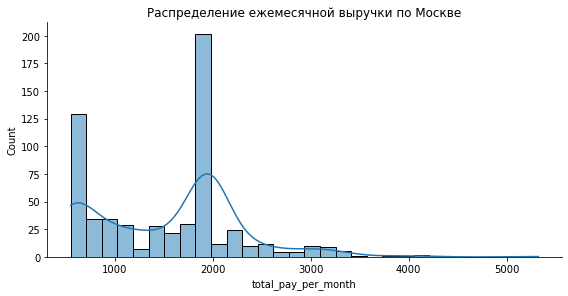

In [58]:
# посмтрим на распределения
sns.displot(clients_m['total_pay_per_month'], kde=True, height=4, aspect=2, bins = 30)
plt.title('Распределение ежемесячной выручки по Москве')
print('дисперсия = ', np.var(clients_m['total_pay_per_month']))
clients_m['total_pay_per_month'].describe()

дисперсия =  653886.3270894113


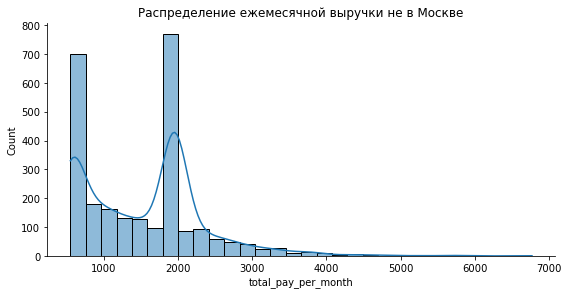

In [59]:
sns.displot(clients_o['total_pay_per_month'], kde=True, height=4, aspect=2, bins = 30)
plt.title('Распределение ежемесячной выручки не в Москве')
print('дисперсия = ', np.var(clients_o['total_pay_per_month']))


Видим что наши данные далеки от нормального распределения

In [60]:
653886 / 564710
# дисперсии отличаются на 15 процентов, не можем считать их равными

1.1579146818721113

**Проводим тесты**

можем провести т-тест, но опираться на него не стоит

In [61]:
stats.ttest_ind(clients_o['total_pay_per_month'], clients_m['total_pay_per_month'], equal_var = False)

Ttest_indResult(statistic=-0.6347555055229303, pvalue=0.5257376663729298)

p-value = 0,52 достаточно большой


<div class="alert alert-info">
значит что с вероятностью 0,52 можем получить такое или ещё большее различие случайно
    
    наши выборки не близки к нормальному распределению, проведём ещё тесты

например U-тест Манна-Уитни для ненормально распределенных данных
</div>

---

In [62]:
stats.mannwhitneyu(clients_o['total_pay_per_month'], clients_m['total_pay_per_month'])

MannwhitneyuResult(statistic=777131.5, pvalue=0.18711697455182996)

In [63]:
stats.mannwhitneyu(clients_o['total_pay_per_month'], clients_m['total_pay_per_month'], alternative = 'less')

MannwhitneyuResult(statistic=777131.5, pvalue=0.18711697455182996)

 p-value = 0.18
 
 С вероятностью 18 процентов мы можем получить такое или более сильное отклонение, нет оснований отвергать нулевую гпотезу

## Общий вывод

**в самом начале обнаружили что 74/500 пользователей не пользуются сообщениями (а это почти 15%)**

Возможно нам стоит пересмотреть пакеты предложений

### Сравниваем тарифы Smart VS Ultra

**SMART**

* СОБЩЕНИЯ (среднее = 29 сообщений/месяц, Дисперсия = 717)
* ЗВОНКИ (Среднее = 419 минут/мес, Дисперсия = 35828)
* ИНТЕРНЕТ (Среднее = 16 гб/мес, Дисперсия = 32)

**ULTRA**

* СОБЩЕНИЯ (среднее = 61 сообщений/месяц, Дисперсия = 2107)
* ЗВОНКИ (Среднее = 545 минут/мес, Дисперсия = 94104)
* ИНТЕРНЕТ (Среднее = 19 гб/мес, Дисперсия = 94)

На тирифе ULTRA все средние показатели выше, и разброс больше

####  Первая гипотеза -- сравниваем тарифы. Получили что:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются (ultra - пользователи платят значительно больше)

####  Вторая гипотеза -- сравниваем регионы. Получили что:

* средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов (p-value = 0.18)



---

<div class="alert alert-info"> 
 Рекомендации :
    тк пользователи SMART (Ежемесячная плата: 550 рублей) чаще выходят за пределы лимитов и переплачивают чем пользователи ULTRA, то тем, кто делает это на регулярной основе стоит предложить им перейти на тариф Ультра
</div>

---